##Импортируем нужные модули

In [2]:
!pip install gdown

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gdown

##Закачиваем датасет

In [4]:
import pathlib

url = 'https://drive.google.com/uc?id=1cOqWs7zmrjFDWbDqF2dmRO4SWLdP31J6&export=download'
output = 'redpandasornot.zip'

gdown.download(url, output, quiet=False)

import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

dataset_dir = pathlib.Path.cwd() / 'redpandasornot'


Downloading...
From: https://drive.google.com/uc?id=1cOqWs7zmrjFDWbDqF2dmRO4SWLdP31J6&export=download
To: /content/redpandasornot.zip
100%|██████████| 196M/196M [00:02<00:00, 84.1MB/s]


Выводим кол-во. изображений в датасете

In [5]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 4325


## Создаем датасеты и кэшируем их

In [6]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4325 files belonging to 2 classes.
Using 3460 files for training.
Found 4325 files belonging to 2 classes.
Using 865 files for validation.
Class names: ['notredpandas', 'redpandas']


## Создаем модель, компилируем её и выводим summary

In [7]:
# create model
num_classes = len(class_names)
model = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

##Обучаем модель и выводим графики точности


Epoch 1/10
109/109 [==============================] - 16s 52ms/step - loss: 0.5644 - accuracy: 0.7220 - val_loss: 0.4643 - val_accuracy: 0.7908
Epoch 2/10
109/109 [==============================] - 2s 20ms/step - loss: 0.4277 - accuracy: 0.8092 - val_loss: 0.3899 - val_accuracy: 0.8208
Epoch 3/10
109/109 [==============================] - 2s 21ms/step - loss: 0.3355 - accuracy: 0.8564 - val_loss: 0.3723 - val_accuracy: 0.8382
Epoch 4/10
109/109 [==============================] - 2s 20ms/step - loss: 0.2595 - accuracy: 0.9000 - val_loss: 0.3539 - val_accuracy: 0.8613
Epoch 5/10
109/109 [==============================] - 2s 20ms/step - loss: 0.1953 - accuracy: 0.9301 - val_loss: 0.3476 - val_accuracy: 0.8821
Epoch 6/10
109/109 [==============================] - 2s 21ms/step - loss: 0.1384 - accuracy: 0.9486 - val_loss: 0.3288 - val_accuracy: 0.8832
Epoch 7/10
109/109 [==============================] - 2s 21ms/step - loss: 0.0996 - accuracy: 0.9676 - val_loss: 0.3891 - val_accuracy: 0.874

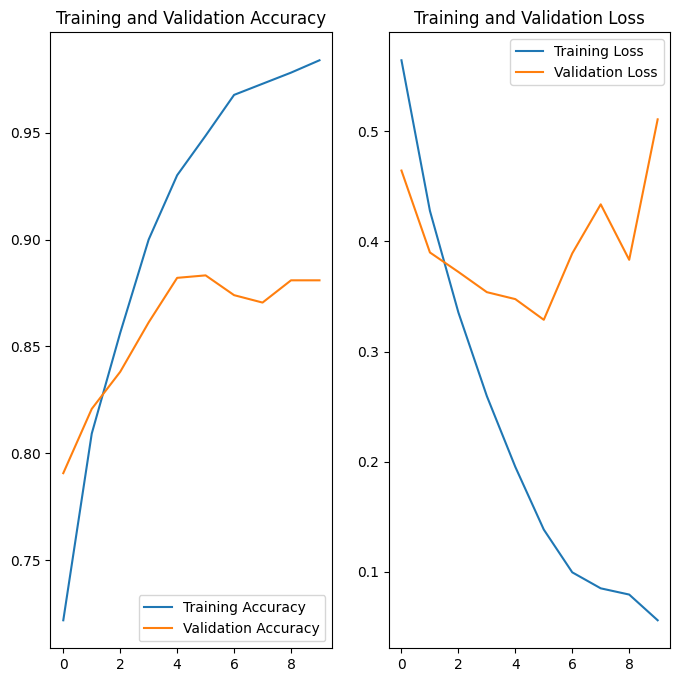

In [8]:
# train the model
epochs = 10
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Решение проблемы переобучения.
##Добавляем аугментацию и регуляризацию (Dropout)

In [9]:
model = Sequential([

	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),


	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

##Повторно обучаем модель с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/20
109/109 [==============================] - 8s 32ms/step - loss: 0.6069 - accuracy: 0.6821 - val_loss: 0.5033 - val_accuracy: 0.7538
Epoch 2/20
109/109 [==============================] - 3s 31ms/step - loss: 0.4993 - accuracy: 0.7668 - val_loss: 0.4172 - val_accuracy: 0.8150
Epoch 3/20
109/109 [==============================] - 3s 30ms/step - loss: 0.4498 - accuracy: 0.7962 - val_loss: 0.4212 - val_accuracy: 0.7861
Epoch 4/20
109/109 [==============================] - 3s 31ms/step - loss: 0.4241 - accuracy: 0.8153 - val_loss: 0.4546 - val_accuracy: 0.8012
Epoch 5/20
109/109 [==============================] - 3s 31ms/step - loss: 0.3887 - accuracy: 0.8332 - val_loss: 0.3531 - val_accuracy: 0.8416
Epoch 6/20
109/109 [==============================] - 3s 30ms/step - loss: 0.3605 - accuracy: 0.8503 - val_loss: 0.3330 - val_accuracy: 0.8486
Epoch 7/20
109/109 [==============================] - 3s 31ms/step - loss: 0.3479 - accuracy: 0.8474 - val_loss: 0.3741 - val_accuracy: 0.8486

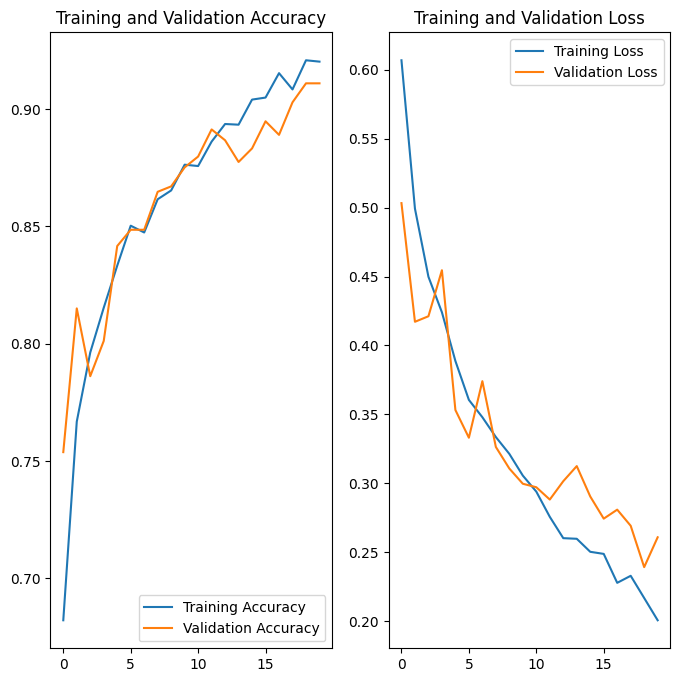

In [10]:
# train the model
epochs = 20
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Делаем инференс на новом изображении

1/1 [==============================] - 0s 104ms/step
На изображении скорее всего redpandas (96.47% вероятность)


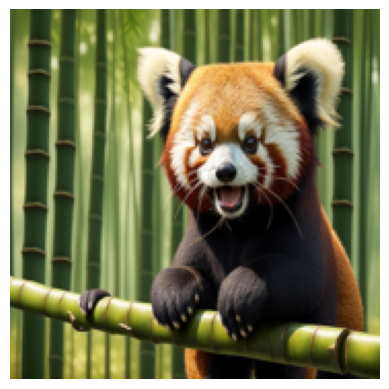

1/1 [==============================] - 0s 18ms/step
На изображении скорее всего notredpandas (76.04% вероятность)


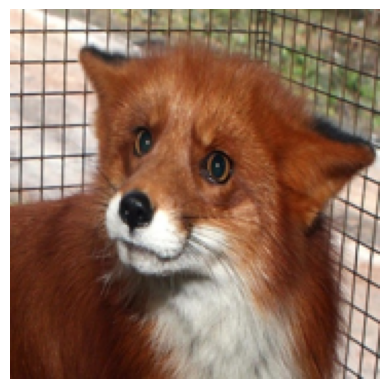

1/1 [==============================] - 0s 18ms/step
На изображении скорее всего notredpandas (99.23% вероятность)


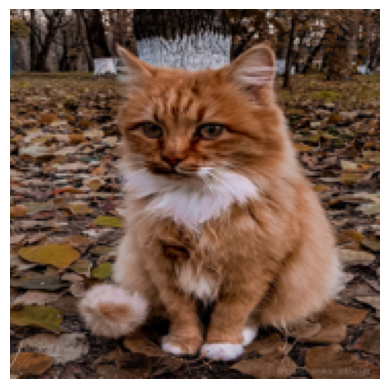

1/1 [==============================] - 0s 17ms/step
На изображении скорее всего notredpandas (79.37% вероятность)


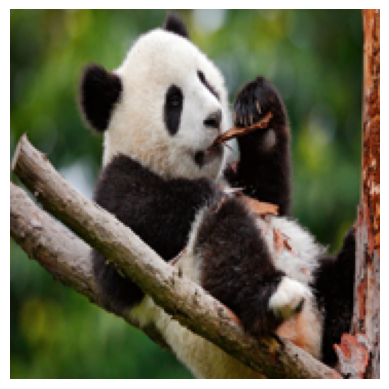

1/1 [==============================] - 0s 20ms/step
На изображении скорее всего notredpandas (99.58% вероятность)


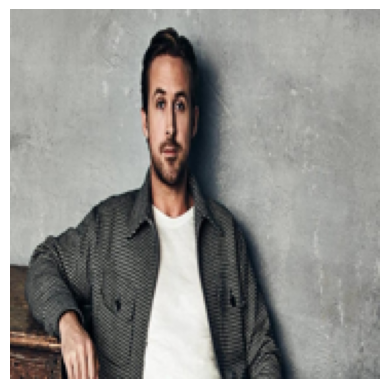

In [11]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
import numpy as np
import io

def inference(images_url):
  i = 1
  for url in images_url:
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    # load image
    img = img.resize((img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # make predictions
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # print inference result
    print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
      class_names[np.argmax(score)],
      100 * np.max(score)))

    # show the image itself
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    i += 1

inference(["https://img.freepik.com/premium-photo/a-red-panda-is-standing-on-a-bamboo-pole_839169-8900.jpg","https://static.mk.ru/upload/entities/2022/11/10/15/articles/detailPicture/36/64/2f/3d/422f5c06bdb1f1c26d7ce27e002d9303.jpg", "https://storage.yandexcloud.net/storage.yasno.media/nat-geo/images/2021/8/26/7a7c1813e4dc452da3aa96f274a1d65c.max-2500x1500.jpg", "https://ruchina.org/fileadmin/_processed_/5/6/csm_pandaeat_bf6ea29b22.jpg", "https://img.redbull.com/images/c_crop,w_1172,h_585,x_0,y_86,f_auto,q_auto/c_scale,w_1200/redbullcom/2016/05/20/1331795954995_2/%D1%80%D0%B0%D0%B9%D0%B0%D0%BD-%D0%B3%D0%BE%D1%81%D0%BB%D0%B8%D0%BD%D0%B3.jpg"])

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# делаем предсказания на валидационном наборе данных
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

# получаем фактические метки из валидационного набора данных
true_classes = np.concatenate([y for x, y in val_ds], axis=0)

# строим матрицу ошибок
confusion = confusion_matrix(true_classes, predicted_classes)

# получаем отчет по классификации
class_report = classification_report(true_classes, predicted_classes, target_names=class_names)

print("Матрица ошибок:")
print(confusion)

print("\nОтчет по классификации:")
print(class_report)

28/28 [==============================] - 0s 9ms/step
Матрица ошибок:
[[383  37]
 [ 40 405]]

Отчет по классификации:
              precision    recall  f1-score   support

notredpandas       0.91      0.91      0.91       420
   redpandas       0.92      0.91      0.91       445

    accuracy                           0.91       865
   macro avg       0.91      0.91      0.91       865
weighted avg       0.91      0.91      0.91       865



##Экспорт файла модели

In [30]:
from google.colab import files

model_file_name = "redpandas.h5"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>